In [1]:
import warnings
warnings.filterwarnings("ignore")

import math

import pandas as pd
import numpy as np
import pandas_ta as ta
import akshare as ak

from datetime import datetime, timedelta
from tqdm import tqdm

pd.options.display.max_rows=None
pd.options.display.max_columns=None

In [2]:
# 1. 获取中证50（000016）的股票列表, '600011'
stock_code_list = ak.index_stock_cons('000016')['品种代码'].to_list()

## 1. 获取基础原始数据

In [147]:
def get_stock_indicator_info(stock_code):
    result = ak.stock_a_indicator_lg(symbol=stock_code).rename(columns={
        'trade_date': 'datetime'
    })
    result = result[['datetime', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_mv']]
    return result

def get_stock_individual_info(stock_code):
    result = pd.DataFrame([ak.stock_individual_info_em(symbol=stock_code).set_index('item').to_dict()['value']]).rename(columns={
                    "总市值": "total_market_cap",
                    "流通市值": "circulating_market_cap",
                    "行业": "industry",
                    "上市时间": "listing_date",
                    "股票代码": "stock_code",
                    "股票简称": "stock_name",
                    "总股本": "total_shares",
                    "流通股": "circulating_shares",
                })
    result = result[['stock_code', 'industry', 'total_shares', 'circulating_shares', 'total_market_cap', 'circulating_market_cap']]
    return result

def get_stock_history_info(stock_code):
    """
    前复权（Forward Adjusted）:
    前复权数据将历史价格向前调整，使得最近的价格不变，而历史价格按照股票的分红、送股和转增等因素进行了调整。这种方式使得历史价格反映了如果投资者持有股票至今所应该得到的收益。前复权数据通常用于图表分析，使得价格连续性更好，并且更适用于基于趋势分析的投资策略。

    后复权（Backward Adjusted）:
    后复权数据将历史价格向后调整，使得历史价格保持不变，而最新的价格根据历史的分红和股权变动进行调整。后复权数据通常用于回测，因为它更贴近实际的交易价格，可以较准确地反映历史的交易情况。

    不复权（Unadjusted）:
    不复权数据是指没有经过任何调整的原始交易数据。不复权数据反映了实际的市场成交价格，但由于不考虑分红和股权变动，因此它不适合用于长期的价格分析。
    """
    result = ak.stock_zh_a_hist(symbol=stock_code, adjust='qfq').rename(
            columns={
                "日期": "datetime",
                "开盘": "open",
                "最高": "high",
                "最低": "low",
                "收盘": "close",
                "成交量": "volume",
                "成交额": "turnover",
                "振幅": "amplitude",
                "涨跌幅": "change_pct",
                "涨跌额": "change_amount",
                "换手率": "turnover_rate",
            }
        )
    result = result[['datetime', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'turnover_rate']]
    result.insert(0, 'stock_code', stock_code)
    return result

In [148]:
raw_data_dir = './raw_data'
for stock_code in tqdm(stock_code_list, desc='Raw Data Extraction...'):
    r1_info = get_stock_individual_info(stock_code)
    r2_info = get_stock_history_info(stock_code)
    r3_info = get_stock_indicator_info(stock_code)
    merge_info = r1_info.merge(r2_info, on=['stock_code']).merge(r3_info, on=['datetime'])
    merge_info.to_pickle(f'{raw_data_dir}/{stock_code}.pkl')

Raw Data Extraction...: 100%|██████████| 300/300 [06:32<00:00,  1.31s/it]


## 2. 原始数据特征变换 & 特征抽取 & 特征工程

In [32]:
def get_stock_selection_label_info_v1(raw_df):
    # 相关参数设定
    max_holding_period = 10
    max_take_profit = 0.15
    max_stop_loss = -0.03
    dataframe = raw_df[['datetime', 'close']].sort_values(by=['datetime'])
    # 计算5日后的收益率
    dataframe["close_in_5_days"] = dataframe["close"].shift(-max_holding_period)
    dataframe["return_5_days"] = dataframe["close_in_5_days"] / dataframe["close"] - 1
    # # 计算5日内的最小值
    dataframe['min_5_days'] = dataframe["close"].rolling(max_holding_period).min()
    dataframe['neg_return_5_days'] = dataframe['min_5_days'] / dataframe["close"] - 1
    # 计算Label
    dataframe['label'] = 0
    condition_1 = dataframe["return_5_days"] > max_take_profit
    condition_2 = dataframe['neg_return_5_days'] > max_stop_loss
    dataframe.loc[condition_1 & condition_2, "label"] = 1 # 买入
    # 输出
    result = raw_df.merge(dataframe[['datetime', 'label']], on=['datetime'])
    return result

def get_stock_selection_label_info_v2(raw_df):
    # 相关参数设定
    dataframe = raw_df[['datetime', 'close']].sort_values(by=['datetime'])
    dataframe["close_in_2_days"] = dataframe["close"].shift(-2)
    dataframe["close_in_1_days"] = dataframe["close"].shift(-1)
    # 计算Label
    dataframe['label'] = 0
    condition_1 = dataframe["close_in_2_days"] > dataframe["close_in_1_days"]
    dataframe.loc[condition_1, "label"] = 1 # 买入
    # 输出
    result = raw_df.merge(dataframe[['datetime', 'label']], on=['datetime'])
    return result

def get_stock_selection_label_info_v3(raw_df):
    N = 10
    dataframe = raw_df[['datetime', 'close']].sort_values(by=['datetime'])
    dataframe["daily_return"] = dataframe["close"].pct_change()
    dataframe["mean_return"] = dataframe["daily_return"].transform(lambda x: x.rolling(N).mean())
    dataframe["std_return"] = dataframe["daily_return"].transform(lambda x: x.rolling(N).std())
    dataframe["close_in_N_days"] = dataframe["close"].shift(-N)
    dataframe["return_N_days"] = dataframe["close_in_N_days"] / dataframe["close"] - 1
    # 构建Target
    dataframe["label"] = 0
    dataframe.loc[dataframe["return_N_days"] > dataframe["mean_return"] + 2 * dataframe["std_return"], "label"] = 1
    # dataframe.loc[dataframe["return_N_days"] < dataframe["mean_return"] - 2 * dataframe["std_return"], "target"] = 2
    # # 删除有NaN的值
    # dataframe.dropna(subset=["mean_return", "std_return", "return_N_days"], inplace=True)
    # 输出
    result = raw_df.merge(dataframe[['datetime', 'label']], on=['datetime'])
    return result


def get_pct_change_info(raw_df):
    transfer_columns = ['open','high', 'low', 'close', 'volume', 'turnover', 'turnover_rate', 'pe','pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_mv']
    for col in transfer_columns:
        raw_df[col] = np.where(raw_df[col].shift(1) == 0, np.nan, raw_df[col] / raw_df[col].shift(1) - 1) # 计算相对上一日的变化率
    return raw_df

def get_log_change_info(raw_df):
    transfer_columns = ['total_shares', 'circulating_shares', 'total_market_cap', 'circulating_market_cap']
    for col in transfer_columns:
        raw_df[col] = np.log(raw_df[col] + 1)
    return raw_df

def get_datetime_info(raw_df):
    dataframe = pd.DataFrame(raw_df['datetime'])
    datetime_series = pd.to_datetime(dataframe['datetime'])
    dataframe['weekday'] = datetime_series.dt.weekday  # 星期几（0=星期一，6=星期日）
    dataframe['day_of_week'] = datetime_series.dt.day_name()  # 星期几的名称
    dataframe['day_of_month'] = datetime_series.dt.day  # 一个月中的第几天
    dataframe['month'] = datetime_series.dt.month  # 月份
    dataframe['season'] = datetime_series.dt.month.map(lambda x: {
        1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn',
        11: 'Autumn', 12: 'Winter'
    }.get(x))
    result = raw_df.merge(dataframe, on=['datetime'])
    return result

def get_factor_info(raw_df):
    # help(ta.donchian)
    base_columns = ['open', 'high', 'low', 'close', 'volume']
    dataframe = raw_df[base_columns]
    dataframe['datetime'] = raw_df['datetime']
    dataframe.set_index(pd.DatetimeIndex(dataframe["datetime"]), inplace=True)
    # Create your own Custom Strategy
    CustomStrategy = ta.Strategy(
        name="CustomStrategy",
        description="",
        ta=[
            {"kind": "ohlc4"},
            {"kind": "sma", "length": 10},
            {"kind": "sma", "length": 20},
            {"kind": "ema", "length": 10},
            {"kind": "ema", "length": 20},
            {"kind": "bbands", "length": 20, "std": 2},
            {"kind": "rsi", "length": 14},
            {"kind": "macd", "fast": 12, "slow": 26, "signal": 9},
            {"kind": "donchian", "length": 20},
        ]
    )
    # To run your "Custom Strategy"
    dataframe.ta.cores = 0
    dataframe.ta.strategy(CustomStrategy)
    dataframe = dataframe[[i for i in dataframe.columns if i not in base_columns]]
    dataframe = dataframe.reset_index(drop=True)
    result = raw_df.merge(dataframe, on=['datetime'])
    return result

In [33]:
wide_data_dir = './wide_data'
for stock_code in tqdm(stock_code_list, desc='Feature Processing...'):
    df = pd.read_pickle(f'./raw_data/{stock_code}.pkl')
    df = get_stock_selection_label_info_v3(df)
    # df = get_pct_change_info(df)
    df = get_log_change_info(df)
    df = get_datetime_info(df)
    df = get_factor_info(df)
    df.dropna(inplace=True)
    df.to_pickle(f'{wide_data_dir}/{stock_code}.pkl')

Feature Processing...: 100%|██████████| 50/50 [00:02<00:00, 18.72it/s]


## 3. 特征数据整合

In [34]:
stock_wide_list = []
for stock_code in tqdm(stock_code_list, desc='Loading Stock...'):
    stock_wide_list.append(pd.read_pickle(f'./wide_data/{stock_code}.pkl'))

df = pd.concat(stock_wide_list)
df['datetime'] = pd.to_datetime(df['datetime'])


Loading Stock...: 100%|██████████| 50/50 [00:00<00:00, 282.29it/s]


## 4. 模型训练

In [35]:
# 使用tensorflow处理原始数据
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)

2.15.0


In [36]:
# 6. 选择固定时间区间的数据
train_start_date = pd.to_datetime('2010-01-01')
train_end_date = pd.to_datetime('2021-12-31')
val_start_date = pd.to_datetime('2022-01-01')
val_end_date = pd.to_datetime('2022-12-31')
test_start_date = pd.to_datetime('2023-01-01')
test_end_date = pd.to_datetime('2023-12-31')

train_data = df[(df['datetime'] >= train_start_date) & (df['datetime'] <= train_end_date)]
validation_data = df[(df['datetime'] >= val_start_date) & (df['datetime'] <= val_end_date)]
test_data = df[(df['datetime'] >= test_start_date) & (df['datetime'] <= test_end_date)]

In [37]:
label_column = 'label'

train_0, train_1 = np.bincount(train_data[label_column])
train_total = train_0 + train_1
print('Train:\nTotal: {}, Normal: {}, Positive: {} \n'.format(train_total, train_0, train_1))
val_0, val_1 = np.bincount(validation_data[label_column])
val_total = val_0 + val_1
print('Validation:\nTotal: {}, Normal: {},Positive: {} \n'.format(val_total, val_0, val_1))
test_0, test_1 = np.bincount(test_data[label_column])
test_total = test_0 + test_1
print('Test:\nTotal: {}, Normal: {},Positive: {} \n'.format(test_total, test_0, test_1))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / train_0) * (train_total / 2.0)
weight_for_1 = (1 / train_1) * (train_total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Train:
Total: 113001, Normal: 81407, Positive: 31594 

Validation:
Total: 11913, Normal: 8926,Positive: 2987 

Test:
Total: 12007, Normal: 8989,Positive: 3018 

Weight for class 0: 0.69
Weight for class 1: 1.79


In [38]:
def get_numeric_boundaries(series, num_bins=40):
    boundaries = pd.qcut(series, num_bins, retbins=True, duplicates='drop')[1].tolist()
    return boundaries

TARGET_FEATURE_NAME = "label"

# 连续特征分桶
NUMERIC_FEATURES = {
    'total_shares': get_numeric_boundaries(train_data['total_shares']),
    'circulating_shares': get_numeric_boundaries(train_data['circulating_shares']),
    'total_market_cap': get_numeric_boundaries(train_data['total_market_cap']),
    'circulating_market_cap': get_numeric_boundaries(train_data['circulating_market_cap']),
    'open': get_numeric_boundaries(train_data['open']),
    'close': get_numeric_boundaries(train_data['close']),
    'high': get_numeric_boundaries(train_data['high']),
    'low': get_numeric_boundaries(train_data['low']),
    'volume': get_numeric_boundaries(train_data['volume']),
    'turnover': get_numeric_boundaries(train_data['turnover']),
    'turnover_rate': get_numeric_boundaries(train_data['turnover_rate']),
    'pe': get_numeric_boundaries(train_data['pe']),
    'pe_ttm': get_numeric_boundaries(train_data['pe_ttm']),
    'pb': get_numeric_boundaries(train_data['pb']),
    'ps': get_numeric_boundaries(train_data['ps']),
    'ps_ttm': get_numeric_boundaries(train_data['ps_ttm']),
    'total_mv': get_numeric_boundaries(train_data['total_mv']),
    'OHLC4': get_numeric_boundaries(train_data['OHLC4']),
    'SMA_10': get_numeric_boundaries(train_data['SMA_10']),
    'SMA_20': get_numeric_boundaries(train_data['SMA_20']),
    'EMA_10': get_numeric_boundaries(train_data['EMA_10']),
    'EMA_20': get_numeric_boundaries(train_data['EMA_20']),
    'BBL_20_2.0': get_numeric_boundaries(train_data['BBL_20_2.0']),
    'BBM_20_2.0': get_numeric_boundaries(train_data['BBM_20_2.0']),
    'BBU_20_2.0': get_numeric_boundaries(train_data['BBU_20_2.0']),
    'BBB_20_2.0': get_numeric_boundaries(train_data['BBB_20_2.0']),
    'BBP_20_2.0': get_numeric_boundaries(train_data['BBP_20_2.0']),
    'RSI_14': get_numeric_boundaries(train_data['RSI_14']),
    'MACD_12_26_9': get_numeric_boundaries(train_data['MACD_12_26_9']),
    'MACDh_12_26_9': get_numeric_boundaries(train_data['MACDh_12_26_9']),
    'MACDs_12_26_9': get_numeric_boundaries(train_data['MACDs_12_26_9']),
    'DCL_20_20': get_numeric_boundaries(train_data['DCL_20_20']),
    'DCM_20_20': get_numeric_boundaries(train_data['DCM_20_20']),
    'DCU_20_20': get_numeric_boundaries(train_data['DCU_20_20']),
}

# 离散特征embedding
INTEGER_CATEGORICAL_FEATURES = {
    'weekday': train_data['weekday'].unique().tolist(),
    'day_of_month': train_data['day_of_month'].unique().tolist(),
    'month': train_data['month'].unique().tolist(),
}
STRING_CATEGORICAL_FEATURES = {
    'industry': train_data['industry'].unique().tolist(),
    'day_of_week': train_data['day_of_week'].unique().tolist(),
    'season': train_data['season'].unique().tolist(),
}


FEATURE_NAMES = list(NUMERIC_FEATURES.keys()) + list(INTEGER_CATEGORICAL_FEATURES.keys()) + list(STRING_CATEGORICAL_FEATURES.keys())

## 尝试使用LightGBM

In [39]:
# import lightgbm as lgb
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, precision_score, recall_score

# for cat_feas in list(INTEGER_CATEGORICAL_FEATURES.keys()) + list(STRING_CATEGORICAL_FEATURES.keys()):
#     le = LabelEncoder()
#     train_data[cat_feas] = le.fit_transform(train_data[cat_feas])
#     test_data[cat_feas] = le.fit_transform(test_data[cat_feas])

# X_train, y_train = train_data[FEATURE_NAMES].to_numpy(), train_data[TARGET_FEATURE_NAME].to_numpy()
# X_test, y_test = test_data[FEATURE_NAMES].to_numpy(), test_data[TARGET_FEATURE_NAME].to_numpy()

# train_dd = lgb.Dataset(X_train, label=y_train)
# test_dd = lgb.Dataset(X_test, label=y_test, reference=train_dd)

# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'num_leaves': 60,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0,
#     'scale_pos_weight': class_weight[0] / class_weight[1]
# }

# gbm = lgb.train(params,
#                 train_dd,
#                 num_boost_round=500,
#                 valid_sets=test_dd)

# # 预测测试集
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# # 将预测结果转换为二进制值
# y_pred_binary = (y_pred >= 0.5).astype(int)

# # 计算准确率
# print(f'Accuracy: {accuracy_score(y_test, y_pred_binary)}')
# print(f'Precision: {precision_score(y_test, y_pred_binary)}')
# print(f'Recall: {recall_score(y_test, y_pred_binary)}')

## 使用Tensorflow

In [40]:
BATCH_SIZE = 128

def df_to_dataset(dataframe, shuffle=True):
  # dataframe = dataframe.drop('datetime', axis=1)
  labels = dataframe[TARGET_FEATURE_NAME]
  dataframe = dataframe[FEATURE_NAMES]
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(BATCH_SIZE)
  return ds

train_ds = df_to_dataset(train_data, shuffle=True)
val_ds = df_to_dataset(validation_data, shuffle=False)
test_ds = df_to_dataset(test_data, shuffle=False)

KeyboardInterrupt: 

In [ ]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        elif feature_name in INTEGER_CATEGORICAL_FEATURES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="int32"
            )
        else:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype="string"
            )
    return inputs

def encode_inputs(inputs):
    encoded_features = []
    embedding_dim = 6
    is_embedding = True

    # 处理连续特征
    for feature_name, boundaries in NUMERIC_FEATURES.items():
        if is_embedding:
            lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='int')
            embedding = tf.keras.layers.Embedding(
                input_dim=len(boundaries) + 1, output_dim=embedding_dim
            )
            encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        else:
            lookup_layer = tf.keras.layers.Discretization(bin_boundaries=boundaries,output_mode='one_hot')
            encoded_feature = lookup_layer(inputs[feature_name])
        encoded_features.append(encoded_feature)

    # 处理INTEGER离散特征
    for feature_name, integer_vocab in INTEGER_CATEGORICAL_FEATURES.items():
        lookup_layer = tf.keras.layers.IntegerLookup(vocabulary=integer_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(integer_vocab) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    # 处理STRING离散特征
    for feature_name, string_vocab in STRING_CATEGORICAL_FEATURES.items():
        lookup_layer = tf.keras.layers.StringLookup(vocabulary=string_vocab)
        embedding = tf.keras.layers.Embedding(
            input_dim=len(string_vocab) + 1, output_dim=embedding_dim
        )
        encoded_feature = embedding(lookup_layer(inputs[feature_name]))
        encoded_features.append(encoded_feature)
    
    print(f"Total Features Size:: {len(encoded_features)}")
    all_features = tf.keras.layers.concatenate(encoded_features)
    return all_features

In [ ]:
LEARNING_RATE = 1e-3
NUM_EPOCH = 20

def run_experiment(model, train_ds, val_ds, test_ds):
    # optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE) # for mac M1/M2
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # for mac M1/M2
    
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
        
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_precision',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True,
    )
    print("Start training the model...")
    history = model.fit(
        train_ds, 
        epochs=NUM_EPOCH,
        validation_data=val_ds, 
        verbose=2,
        callbacks=[early_stopping],
        class_weight=class_weight
    )
    print("Model training finished")

    # loss, auc = model.evaluate(test_ds, verbose=0)
    # print(f"Test AUC::{round(auc * 100, 2)}%")

In [ ]:
dropout_rate = 0.2
hidden_units = [128, 32]

In [ ]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = tf.keras.layers.Dense(units)(features)
        features = tf.keras.layers.BatchNormalization()(features)
        features = tf.keras.layers.ReLU()(features)
        features = tf.keras.layers.Dropout(dropout_rate)(features)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

baseline_model = create_baseline_model()
# tf.keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")
run_experiment(baseline_model, train_ds, val_ds, test_ds)

Total Features Size:: 40
Start training the model...
Epoch 1/20
522/522 - 11s - loss: 0.7092 - tp: 9955.0000 - fp: 22004.0000 - tn: 26125.0000 - fn: 8714.0000 - accuracy: 0.5401 - precision: 0.3115 - recall: 0.5332 - auc: 0.5514 - val_loss: 0.7180 - val_tp: 1474.0000 - val_fp: 3854.0000 - val_tn: 1755.0000 - val_fn: 470.0000 - val_accuracy: 0.4275 - val_precision: 0.2767 - val_recall: 0.7582 - val_auc: 0.5565 - 11s/epoch - 21ms/step
Epoch 2/20
522/522 - 4s - loss: 0.6665 - tp: 11494.0000 - fp: 20629.0000 - tn: 27500.0000 - fn: 7175.0000 - accuracy: 0.5838 - precision: 0.3578 - recall: 0.6157 - auc: 0.6305 - val_loss: 0.7319 - val_tp: 1317.0000 - val_fp: 3381.0000 - val_tn: 2228.0000 - val_fn: 627.0000 - val_accuracy: 0.4693 - val_precision: 0.2803 - val_recall: 0.6775 - val_auc: 0.5477 - 4s/epoch - 8ms/step
Epoch 3/20
522/522 - 4s - loss: 0.6520 - tp: 11824.0000 - fp: 19281.0000 - tn: 28848.0000 - fn: 6845.0000 - accuracy: 0.6089 - precision: 0.3801 - recall: 0.6333 - auc: 0.6607 - val

In [128]:
# baseline_model.save('./stock_selection_base_model')
# reloaded_model = tf.keras.models.load_model('./stock_selection_base_model')

In [129]:
# samples = df_to_dataset(test_data.iloc[:100, :], shuffle=False, batch_size=10)

In [130]:
test_labels = []
for _, labels in test_ds:
    test_labels.extend(labels.numpy())

test_predictions = baseline_model.predict(test_ds).squeeze()

60/60 [==============================] - 1s 5ms/step


In [131]:
test_df = pd.DataFrame()
test_df['true_label'] = test_labels
test_df['prediction'] = test_predictions

In [132]:
# 预测最高的打分，实际label都不是1
test_df.sort_values(by='prediction', ascending=False).head(20)

,true_label,prediction
1626,0,0.999362
3733,0,0.999087
2416,0,0.998462
736,0,0.997296
4006,0,0.997232
4190,0,0.997126
4191,0,0.997008
7335,0,0.996923
4244,0,0.996649
4188,0,0.996502


In [133]:
# import matplotlib.pyplot as plt

# plt.hist(true_positives_scores, bins=50, alpha=0.5, label='True Positives')
# plt.hist(false_positives_scores, bins=50, alpha=0.5, label='False Positives')
# plt.xlabel('Scores')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

Legitimate Transactions Detected (True Negatives):  6899
Legitimate Transactions Incorrectly Detected (False Positives):  537
Fraudulent Transactions Missed (False Negatives):  109
Fraudulent Transactions Detected (True Positives):  18
Total Fraudulent Transactions:  127


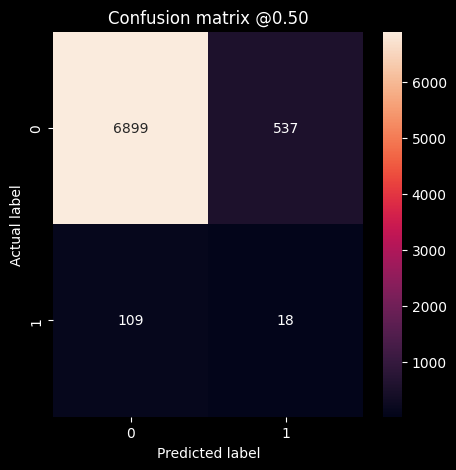

In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

plot_cm(test_labels, test_predictions)
